In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, signal
import itertools, operator, random, math
from scipy.sparse.linalg import spsolve_triangular
from sklearn import linear_model
import utils as ut
%matplotlib inline

In [2]:
def abr(t, pop):
    la, lb, lr, ra, rb, rr = pop
    ka, da, dab = 400, 2, 400
    kb, kbb, db, dba = 2, 30, 2.8, 30
    kr, krb, dr = 0.1, 1.5, 0.2

    dladt = ka*(1-la-ra)*lr - da*la - dab*la*lb**2
    dlbdt = (1-lb-rb)*(kb + kbb*lb) - db*lb - dba*la*lb**2
    dlrdt = (1-lr-rr)*(kr+krb*lb) - dr*lr
    dradt = ka*(1-la-ra)*rr - da*ra - dab*ra*rb**2
    drbdt = (1-lb-rb)*(kb + kbb*rb) - db*rb - dba*ra*rb**2
    drrdt = (1-lr-rr)*(kr+krb*rb) - dr*rr
    dpop = np.array([dladt, dlbdt, dlrdt, dradt, drbdt, drrdt])
    return dpop

In [3]:
dt = 0.01
pts= int(60/dt)
tspan = np.linspace(dt, 60, num=pts)
pop0 = [1, 0, 0, 0, 1, 1]
sol = integrate.solve_ivp(abr, [tspan[0], tspan[-1]], pop0, method='RK45', rtol=1e-10, atol=1e-10,t_eval=tspan)
dpop_std = abr(sol.t, sol.y)

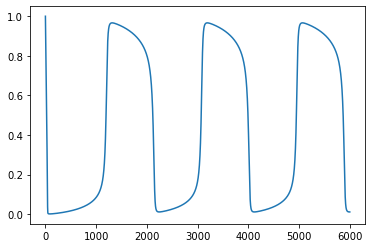

In [4]:
plt.plot(sol.y[0])

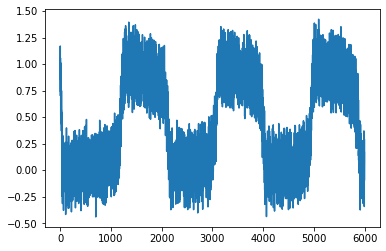

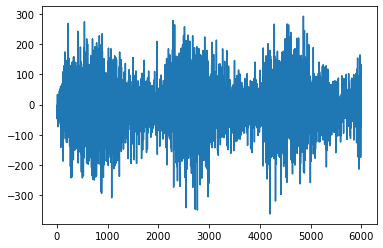

In [4]:
pop = sol.y.copy()
pop = pop + 0.5*np.random.rand(sol.y.shape[0], sol.y.shape[1])
pop -= 0.2*np.random.rand(sol.y.shape[0], sol.y.shape[1])
pop -= 0.3*np.random.rand(sol.y.shape[0], sol.y.shape[1])
dpop = abr(sol.t, pop)
plt.plot(pop[0])
plt.show()
plt.plot(dpop[0])
plt.show()

In [5]:
import matlab.engine
eng = matlab.engine.start_matlab()
dpop_diff = []
for i, x in enumerate(pop):
    A = matlab.double(list(x))
    data_test = eng.TVRegDiff(A, 10,1e-3)
    dpop_diff.append(data_test[1:])
dpop_diff = np.reshape(dpop_diff, (6, 6000))

In [6]:
pop_new, dpop_new = [], []
for i in range(6):
    tmp = (np.cumsum(dpop_diff[i])*dt)
    new = tmp - np.mean(tmp) - np.mean(pop[i])
    pop_new.append(new[20:-20])
    dpop_new.append(dpop_diff[i][20:-20])

In [7]:
dpop_new2, pop_new2 = dpop_new.copy(), pop_new.copy()
for i in range(3):
    adj = np.mean(pop_new2[i] + pop_new2[3+i])
    print(adj)
    pop_new2[i] = pop_new2[i]/60 +0.5
    pop_new2[3+i] = pop_new2[3+i]/60 + 0.5
    dpop_new2[i] /= 60
    dpop_new2[3+i] /= 60

-0.9285825391705813
-0.8660895872060981
-0.8901710480936039


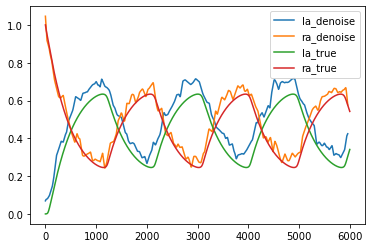

In [8]:
plt.plot(pop_new2[2], label='la_denoise')
plt.plot(pop_new2[5], label='ra_denoise')
plt.plot(sol.y[2],label='la_true' )
plt.plot(sol.y[5], label='ra_true')
plt.legend()

In [9]:
u, s, v = np.linalg.svd(pop_new, full_matrices=False)
pop_newx = u[:,:3].dot(v[:3,:])

In [10]:
dpop_newx = abr(sol.t[20:-20], pop_newx)

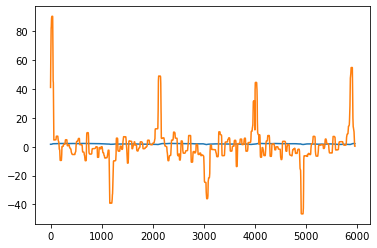

In [11]:
plt.plot(dpop_newx[1])
plt.plot(dpop_new[1]*60)

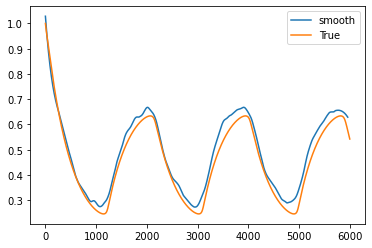

In [12]:
from scipy.signal import savgol_filter

smoothed_1dg = savgol_filter(pop_new2, window_length = 501, polyorder = 3)
plt.plot(smoothed_1dg[5], label='smooth')
plt.plot(sol.y[5], label ='True')
plt.legend()

In [14]:
# smoothed_1dg2 = savgol_filter(dpop_new2, window_length = 101, polyorder = 3)
# plt.plot(smoothed_1dg2[0])
# plt.plot(dpop_std[0])

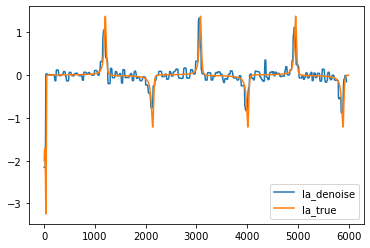

In [15]:
plt.plot(dpop_new2[0], label='la_denoise')
# plt.plot(dpop_new2[5], label='ra_denoise')
plt.plot(dpop_std[0],label='la_true' )
# plt.plot(dpop_std[5], label='ra_true')
plt.legend()

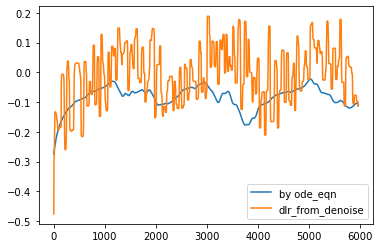

In [16]:
dpop_std_curr = abr(sol.t[20:-20], smoothed_1dg)
plt.plot(dpop_std_curr[5], label='by ode_eqn')
# plt.plot(dpop_std_curr[3], label='dra_denoise')
plt.plot(dpop_new2[5], label='dlr_from_denoise')
# plt.plot(dpop_new2[3], label='dra_from_denoise')
plt.legend()

orange -> denoised time derivated value
blue -> ode_eqn calcaulted value 

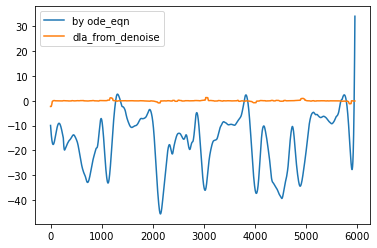

In [434]:
dpop_std_curr = abr(sol.t[20:-20], smoothed_1dg)
plt.plot(dpop_std_curr[0], label='by ode_eqn')
# plt.plot(dpop_std_curr[3], label='dra_denoise')
plt.plot(dpop_new2[0], label='dla_from_denoise')
# plt.plot(dpop_new2[3], label='dra_from_denoise')
plt.legend()

In [17]:
# u, s, v = np.linalg.svd(sol.y, full_matrices =False)
theta, descr = ut.lib_terms(np.reshape(smoothed_1dg,(6,5960)),3,['la', 'lb', 'lr', 'ra', 'rb','rr'])
# clf = linear_model.Lasso(alpha=1e-3, fit_intercept=False, max_iter=5e3)
# clf.fit(theta,np.reshape(dpop_new2,(6,5960)).T)
# Xi = clf.coef_
Xi_curr = ut.sparsifyDynamics(theta,np.reshape(dpop_new2,(6,5960)).T, 0.001)

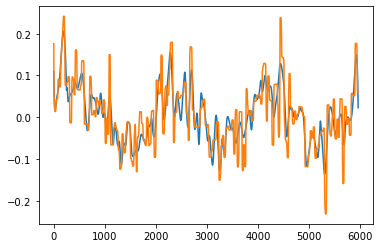

In [18]:
plt.plot(theta.dot(Xi_curr)[:,2])
plt.plot(dpop_new2[2])

In [14]:
pop2 = np.reshape(smoothed_1dg,(6,5960))[:,0]

In [15]:
sol_res = integrate.solve_ivp(ut.sparseGalerkin, [tspan[20], tspan[-20]], pop2, method='BDF', atol=1e-12, rtol=1e-12, t_eval=tspan[20:-20],args=(Xi_curr,3))

In [20]:
Xi_curr

array([[-8.44848920e+03,  6.09529012e+03,  9.59931837e+02,
        -1.25763856e+03, -4.57836487e+02, -2.19405731e+03],
       [ 6.15853286e+03, -8.33448971e+03, -1.70951369e+03,
         8.59385613e+03, -6.20433509e+03,  2.07305927e+03],
       [ 2.84292703e+04, -1.45403163e+04, -5.21835985e+03,
        -7.90013313e+03,  1.33173359e+04,  7.52528159e+03],
       [-4.58086837e+03, -2.32630405e+03,  4.56717027e+03,
         6.68479671e+03, -1.16834214e+04,  6.50916771e+02],
       [ 6.22709480e+03, -9.48448878e+03, -1.85189480e+03,
         9.70331719e+03, -1.04454940e+04,  2.79817733e+03],
       [ 2.42488693e+04, -6.36827142e+03, -5.79046298e+03,
        -1.24281399e+04,  2.28803131e+04,  3.16572772e+03],
       [-8.19541179e+03,  3.93256415e+03,  4.12666615e+03,
         3.64085167e+03, -5.87536985e+03, -2.67435969e+03],
       [-4.65527107e+01,  1.36764225e+03,  1.59146564e+03,
        -1.05524390e+04,  3.23481656e+03,  9.66033793e+02],
       [-3.17439296e+04,  1.97949815e+04,  8.326

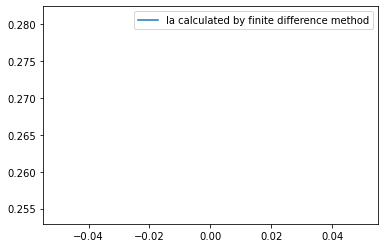

In [19]:
plt.plot(sol_res.y[0],label ='la calculated by finite difference method')
plt.legend()

In [415]:
df_term = ut.visual_param(Xi, descr)
df_term

,la,lb,lr,ra,rb,rr
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rr,-0.247226,0.073688,0.000000,0.000000,-0.361042,0.000000
rb,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ra,0.000000,0.000000,0.000000,0.000000,0.000000,-0.030715
lr,0.000000,0.000000,-0.038953,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
lalarb,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lalara,1.216070,-1.552979,0.000000,-1.319231,1.876226,0.000000
lalalr,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lalalb,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [419]:
df_term.sort_values(by=['la'])['la'][:5], df_term.sort_values(by=['la'])['la'][-6:]

(rarbrr   -3.317502
 lrrara   -0.474794
 rr       -0.247226
 lalala   -0.054805
 lblbrr    0.000000
 Name: la, dtype: float64,
 lrrarr    0.000000
 rarara    0.127230
 lrlr      0.387017
 lbrarr    0.763198
 lalara    1.216070
 lalblr    1.810514
 Name: la, dtype: float64)